In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib.cm as cm
np.random.seed(1)

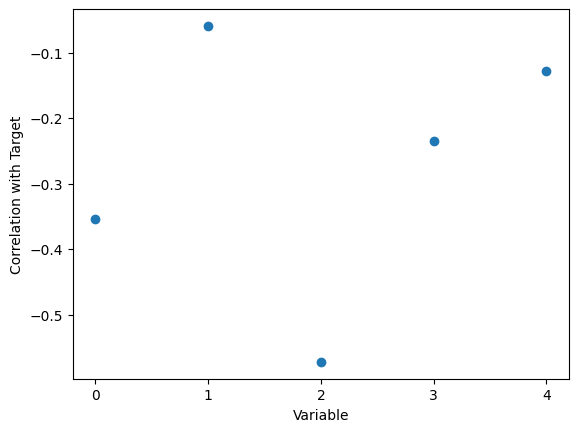

In [2]:
# (a) Loading data and correlations
X_train = pd.read_csv('train.csv', header=None)
y_train = X_train.iloc[:, -1]
X_train.drop(5, axis=1, inplace=True)
corrs = []
for i in range(X_train.shape[1]):
    corrs.append(np.corrcoef(X_train.iloc[:, i], y_train)[0, 1])
plt.scatter(range(5), corrs)
plt.xlabel('Variable')
plt.ylabel('Correlation with Target')
plt.xticks([0, 1, 2, 3, 4]);             # The semicolon suppresses the output of this from showing

In [3]:
# (b) Fitting the bagging model
p = 100                        # Number of trees to be used
# By setting max_features to 1.0, all features are used and therefore this is simply bagging
bagging = RandomForestRegressor(max_features=1.0, n_estimators=p, bootstrap=True)
bagging.fit(X_train, y_train);

In [4]:
# (c) Loading the test data...
X_test = pd.read_csv('test.csv', header=None)
y_test = X_test.iloc[:, -1]
X_test.drop(5, axis=1, inplace=True)

# ...and computing the correlations between the different trees in the model
def prediction_corr(model, X, y):
    S = []
    for i, tree in enumerate(model.estimators_):
        y_pred_i = tree.predict(X)
        for j in range(i+1, p):
            tree = model.estimators_[j]
            y_pred_j = tree.predict(X)
            S.append(np.corrcoef(y_pred_i, y_pred_j)[0, 1])
    return np.mean(S)
print(prediction_corr(bagging, X_test, y_test))

0.6461962467609036


In [5]:
# (d) Computing the correlations between the residuals instead
def residual_corr(model, X, y):
    S = []
    for i, tree in enumerate(model.estimators_):
        y_res_i = y - tree.predict(X)
        for j in range(i+1, p):
            tree = model.estimators_[j]
            y_res_j = y - tree.predict(X)
            S.append(np.corrcoef(y_res_i, y_res_j)[0, 1])
    return np.mean(S)
print(residual_corr(bagging, X_test, y_test))

0.5948010704602513


We see that the correlation between the residuals is lower than between the predicted values. This makes sense, because all the models *should* be predicting similar values for the data. 

Meanwhile, if the models were trained on independent data (and correctly described the data), the residuals for different model predictors should be much smaller.

The rather high residual correlation can therefore explained as a combination of a) datasets from bagging having large overlaps and b) the model not correctly describing the data.

In [6]:
# (e) Training RFs with different numbers of subsampled features for each tree
RFs = dict()
Qs = np.linspace(0.2, 1, 5) 
for q in Qs:
    rf = RandomForestRegressor(max_features=q, n_estimators=p, bootstrap=True)
    rf.fit(X_train, y_train)
    RFs[q] = rf

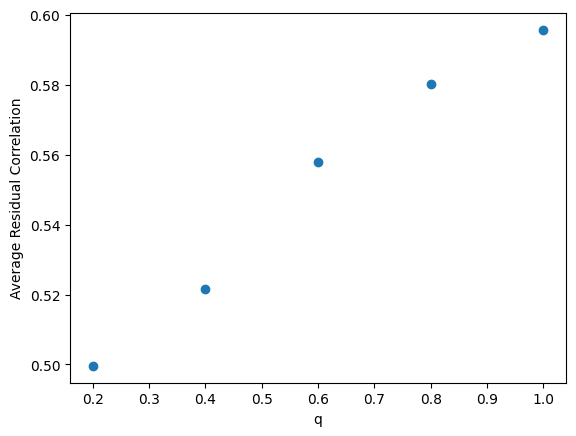

In [7]:
# (f) Residual correlations for different numbers of features
rf_res_corr = []
for q in Qs:
    rf = RFs[q]
    rf_res_corr.append(residual_corr(rf, X_test, y_test))
plt.scatter(Qs, rf_res_corr)
plt.xlabel('q')
plt.ylabel('Average Residual Correlation');

We see clearly that the larger the feature set for each tree is, the stronger the correlation, and for $q = 1.0$ we get the correlations obtained in (d).

However, we see also that even when every tree uses only one feature, the residuals are strongly correlated. This indicates that the models do not fit the data well as noted above.

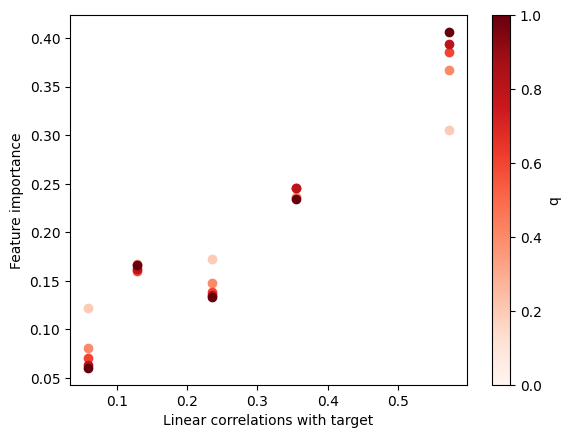

In [8]:
# (g) Computing the feature importances and plotting them against the linear correlations
cmap = cm.Reds
for q in Qs:
    rf = RFs[q]
    imp = rf.feature_importances_
    color = cm.Reds(q)
    plt.scatter(np.abs(corrs), imp, color=color) # Use absolute values because we don't care about the sign
sm = plt.cm.ScalarMappable(cmap=cmap)
cbar = plt.colorbar(sm)
cbar.set_label('q')
plt.xlabel('Linear correlations with target')
plt.ylabel('Feature importance');

There is clearly a strong correlation between the two measures of feature relevance, and we see that for more features included (dark red) the RF feature importance for highly correlated variables increases (or stays the same) while for weakly correlated variables it decreases (or stays the same).